# IEOR 4571 Project_1 (MovieLen Dataset)

Authors: 
Ying Du (yd2519)
Chenlu Jia (cj2616)
Chengyou Ju (cj2624)
Jiaqi Tang (jt3169)

## 1. Data cleaning and dataset choices

In [659]:
#import all packages that will be used
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import sys
import time
import pickle
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
#from surprise.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import GridSearchCV
#from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing
from fuzzywuzzy import fuzz
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

In [660]:
#Load the movie dataset
movies = pd.read_csv('ml-20m/movies.csv')
genome_scores = pd.read_csv('ml-20m/genome-scores.csv')
tags = pd.read_csv('ml-20m/tags.csv')
genome_tags = pd.read_csv('ml-20m/genome-tags.csv')
ratings = pd.read_csv('ml-20m/ratings.csv')

In [661]:
# map movie to id:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [662]:
# Get the rating frequency of all movies
df_movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,49695
2,22243
3,12735
4,2756
5,12161


Text(0, 0.5, 'number of ratings')

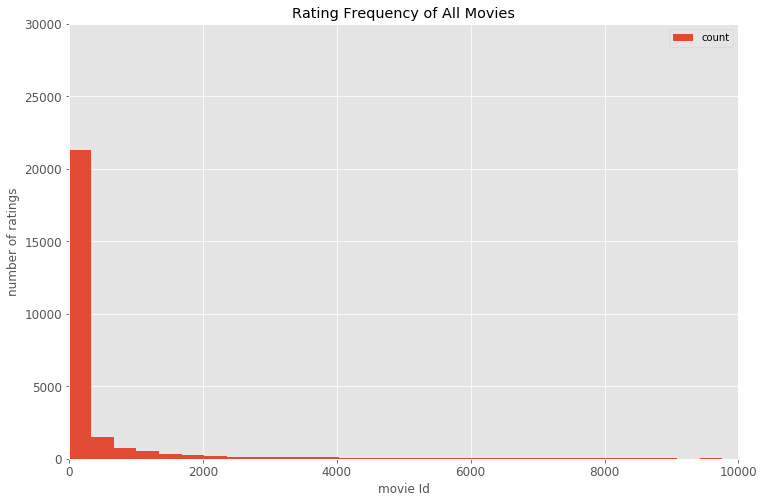

In [306]:
# Plot the rating frequency of all movies
ax = df_movies_cnt.sort_values('count', ascending=False).reset_index(drop=True).plot.hist(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12,
        bins=200)
ax.set_xlim(0, 10000)
ax.set_ylim(0, 30000)
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

#### From the graph above, we can tell that most movies are not rated by a number of people. Therefore, when choosing a smaller dataset, we first look at the distribution of the rating frequency for each movie.

In [159]:
# Get the quantiles of the movie rating counts for each movie
df_movies_cnt['count'].quantile(np.arange(1, 0.8, -0.01))

1.00    67310.00
0.99    14388.69
0.98     8835.78
0.97     6219.97
0.96     4700.56
0.95     3612.95
0.94     2847.00
0.93     2285.98
0.92     1848.00
0.91     1543.00
0.90     1305.70
0.89     1120.00
0.88      970.84
0.87      844.41
0.86      727.00
0.85      632.55
0.84      558.00
0.83      486.00
0.82      433.26
0.81      386.83
Name: count, dtype: float64

### (a) 1% movies and 1% users

In [679]:
# Filter the data and keep the top 1% movies with the largest numbers of ratings
popularity_thres = 14388.69
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (20000263, 4)
shape of ratings data after dropping unpopular movies:  (6711289, 4)


In [680]:
# Get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])

Text(0, 0.5, 'number of ratings')

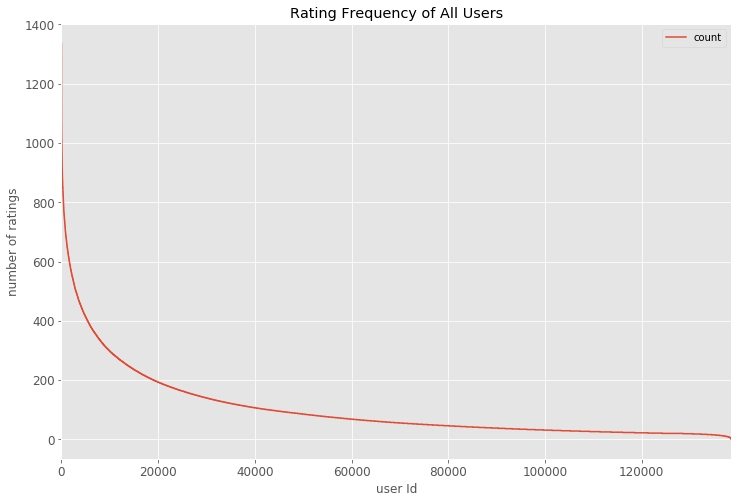

In [31]:
# Plot rating frequency of all movies
ax = df_users_cnt.sort_values('count', ascending=False).reset_index(drop=True).plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12)
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

#### From the graph above, we can tell that most users did not rate a number of movies. Therefore, when choosing a smaller dataset, we want to look at the distribution of the number of movies rated by each user.

In [158]:
df_users_cnt['count'].quantile(np.arange(1, 0.8, -0.01))

1.00    1335.0
0.99     627.0
0.98     513.0
0.97     444.0
0.96     395.0
0.95     358.0
0.94     327.0
0.93     302.0
0.92     282.0
0.91     264.0
0.90     248.0
0.89     233.0
0.88     220.0
0.87     208.0
0.86     197.0
0.85     188.0
0.84     179.0
0.83     171.0
0.82     163.0
0.81     156.0
Name: count, dtype: float64

In [681]:
# Filter the data and keep the top 1% users who rate the largest number of movies
ratings_thres = 627
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (20000263, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (0, 4)


In [682]:
# list the movie titles that survive the filtering
movie_list_rating = df_ratings_drop_users.movieId.unique().tolist()

In [683]:
#filter the movies data frame
movies = movies[movies.movieId.isin(movie_list_rating)]

In [ ]:
df_ratings_drop_users.drop(['timestamp'],1, inplace=True)
df_ratings_drop_users.head()

In [37]:
#Merge the movieId column in movies and the ratings dataset so we can have the movieIds as the feature
ratings_f1 = pd.merge(movies[['movieId']], df_ratings_drop_users, on="movieId", how="right")

In [38]:
ratings_f1.head()

,movieId,userId,rating
0,1,24,4.0
1,1,54,4.0
2,1,58,5.0
3,1,91,4.0
4,1,116,3.0


In [39]:
#Make a matrix with userIds as columns, movieIds as rows and scoring as entries
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [40]:
ratings_f2.head()

userId,24,54,58,91,104,116,134,156,208,247,...,138270,138301,138307,138325,138382,138397,138406,138411,138437,138474
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,5.0,4.0,0.0,3.0,4.0,5.0,4.0,0.0,...,0.0,2.5,3.5,5.0,3.0,0.0,4.0,5.0,4.0,5.0
2,0.0,3.0,0.0,3.5,0.0,2.0,0.0,5.0,0.0,0.0,...,0.0,2.5,2.5,3.0,4.0,0.0,3.0,0.0,0.0,4.0
3,0.0,0.0,0.0,3.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0
5,2.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
6,4.0,3.0,4.5,0.0,0.0,1.5,3.0,4.0,0.0,5.0,...,2.0,3.5,2.0,4.5,0.0,5.0,0.0,5.0,4.0,5.0


### (b) 1% movies, 2%users

In [667]:
# Filter the data and keep the top 1% movies with the largest numbers of ratings
popularity_thres = 14388.69
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies2 = ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (20000263, 4)
shape of ratings data after dropping unpopular movies:  (6711289, 4)


In [668]:
# Get number of ratings given by every user
df_users_cnt2 = pd.DataFrame(df_ratings_drop_movies2.groupby('userId').size(), columns=['count'])

In [669]:
df_users_cnt2['count'].quantile(np.arange(1, 0.8, -0.01))

1.00    268.0
0.99    212.0
0.98    191.0
0.97    176.0
0.96    164.0
0.95    153.0
0.94    145.0
0.93    136.0
0.92    129.0
0.91    122.0
0.90    116.0
0.89    111.0
0.88    106.0
0.87    102.0
0.86     97.0
0.85     93.0
0.84     89.0
0.83     86.0
0.82     82.0
0.81     79.0
Name: count, dtype: float64

In [670]:
# Filter the data and keep the top 2% users who rate the largest number of movies
ratings_thres = 191
active_users = list(set(df_users_cnt2.query('count >= @ratings_thres').index))
df_ratings_drop_users2 = df_ratings_drop_movies2[df_ratings_drop_movies2.userId.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users2.shape)

shape of original ratings data:  (20000263, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (589681, 4)


In [671]:
# list the movie titles that survive the filtering
movie_list_rating = df_ratings_drop_users2.movieId.unique().tolist()

#filter the movies data frame
movies = movies[movies.movieId.isin(movie_list_rating)]

In [672]:
ratings_f1 = pd.merge(movies[['movieId']], df_ratings_drop_users2, on="movieId", how="right")
ratings_f2_2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)
ratings_f2_2.head()

userId,91,116,156,208,294,359,427,586,587,614,...,137854,137885,138019,138134,138208,138254,138256,138325,138387,138411
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,3.0,5.0,4.0,4.5,5.0,4.0,2.5,5.0,3.0,...,4.5,5.0,4.5,4.5,3.0,4.0,3.0,5.0,2.5,5.0
2,3.5,2.0,5.0,0.0,4.5,0.0,0.5,3.0,2.0,0.0,...,3.0,3.0,0.0,2.0,2.0,3.5,0.0,3.0,3.5,0.0
6,0.0,1.5,4.0,0.0,3.5,5.0,5.0,4.5,0.0,2.5,...,4.5,5.0,0.0,0.0,3.0,4.5,3.0,4.5,0.0,5.0
10,4.0,2.0,4.0,0.0,3.5,4.0,2.0,4.0,4.0,3.0,...,3.0,3.0,0.0,3.0,2.0,4.0,2.5,3.5,2.5,3.5
11,4.0,2.0,5.0,3.0,3.0,4.0,2.0,2.5,4.0,0.0,...,3.0,3.0,3.5,0.0,3.0,0.0,0.0,0.0,4.0,2.5


### (c) 1% movies, 3% users

In [155]:
# Filter the data and keep the top 1% movies with the largest numbers of ratings
popularity_thres = 14388.69
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies3 = ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies3.shape)

shape of original ratings data:  (20000263, 4)
shape of ratings data after dropping unpopular movies:  (6711289, 4)


In [160]:
# Get number of ratings given by every user
df_users_cnt3 = pd.DataFrame(df_ratings_drop_movies3.groupby('userId').size(), columns=['count'])
df_users_cnt3['count'].quantile(np.arange(1, 0.8, -0.01))

1.00    268.0
0.99    212.0
0.98    191.0
0.97    176.0
0.96    164.0
0.95    153.0
0.94    145.0
0.93    136.0
0.92    129.0
0.91    122.0
0.90    116.0
0.89    111.0
0.88    106.0
0.87    102.0
0.86     97.0
0.85     93.0
0.84     89.0
0.83     86.0
0.82     82.0
0.81     79.0
Name: count, dtype: float64

In [162]:
# Filter the data and keep the top 3% users who rate the largest number of movies
ratings_thres = 176
active_users = list(set(df_users_cnt3.query('count >= @ratings_thres').index))
df_ratings_drop_users3 = df_ratings_drop_movies3[df_ratings_drop_movies3.userId.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users3.shape)

shape of original ratings data:  (20000263, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (845185, 4)


In [177]:
# list the movie titles that survive the filtering
movie_list_rating = df_ratings_drop_users3.movieId.unique().tolist()

#filter the movies data frame
movies = movies[movies.movieId.isin(movie_list_rating)]

In [178]:
ratings_f1 = pd.merge(movies[['movieId']], df_ratings_drop_users3, on="movieId", how="right")
ratings_f2_3 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)
ratings_f2_3.head()

userId,58,91,116,156,208,294,298,347,359,367,...,138135,138148,138208,138211,138254,138256,138301,138325,138387,138411
movieId,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,3.0,5.0,4.0,4.5,4.0,4.0,5.0,3.0,...,3.5,0.0,3.0,4.0,4.0,3.0,2.5,5.0,2.5,5.0
2,0.0,3.5,2.0,5.0,0.0,4.5,3.0,2.0,0.0,2.0,...,3.5,3.0,2.0,0.0,3.5,0.0,2.5,3.0,3.5,0.0
6,4.5,0.0,1.5,4.0,0.0,3.5,5.0,0.0,5.0,4.0,...,0.0,5.0,3.0,0.0,4.5,3.0,3.5,4.5,0.0,5.0
10,0.0,4.0,2.0,4.0,0.0,3.5,4.0,2.0,4.0,3.5,...,3.5,3.5,2.0,0.0,4.0,2.5,2.0,3.5,2.5,3.5
11,4.5,4.0,2.0,5.0,3.0,3.0,3.0,0.0,4.0,0.0,...,4.0,3.5,3.0,0.0,0.0,0.0,0.0,0.0,4.0,2.5


### (d) 2% movies, 3% users

In [169]:
# Filter the data and keep the top 1% movies with the largest numbers of ratings
popularity_thres = 8835.78
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies4 = ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies4.shape)

shape of original ratings data:  (20000263, 4)
shape of ratings data after dropping unpopular movies:  (9733001, 4)


In [170]:
# Get number of ratings given by every user
df_users_cnt4 = pd.DataFrame(df_ratings_drop_movies4.groupby('userId').size(), columns=['count'])
df_users_cnt4['count'].quantile(np.arange(1, 0.8, -0.01))

1.00    535.00
0.99    352.94
0.98    305.00
0.97    274.00
0.96    250.00
0.95    231.00
0.94    215.00
0.93    201.00
0.92    189.00
0.91    178.00
0.90    169.00
0.89    160.00
0.88    152.00
0.87    145.00
0.86    138.00
0.85    132.00
0.84    126.00
0.83    121.00
0.82    116.00
0.81    111.00
Name: count, dtype: float64

In [171]:
# Filter the data and keep the top 3% users who rate the largest number of movies
ratings_thres = 274
active_users = list(set(df_users_cnt4.query('count >= @ratings_thres').index))
df_ratings_drop_users4 = df_ratings_drop_movies4[df_ratings_drop_movies4.userId.isin(active_users)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users4.shape)

shape of original ratings data:  (20000263, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (1409932, 4)


In [179]:
# list the movie titles that survive the filtering
movie_list_rating = df_ratings_drop_users4.movieId.unique().tolist()

#filter the movies data frame
movies = movies[movies.movieId.isin(movie_list_rating)]

In [180]:
ratings_f1 = pd.merge(movies[['movieId']], df_ratings_drop_users4, on="movieId", how="right")
ratings_f2_4 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)
ratings_f2_4.head()

userId,54,58,91,116,156,208,294,298,347,359,...,138162,138208,138211,138254,138301,138307,138325,138387,138397,138411
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,5.0,4.0,3.0,5.0,4.0,4.5,4.0,4.0,5.0,...,4.0,3.0,4.0,4.0,2.5,3.5,5.0,2.5,0.0,5.0
2,3.0,0.0,3.5,2.0,5.0,0.0,4.5,3.0,2.0,0.0,...,3.0,2.0,0.0,3.5,2.5,2.5,3.0,3.5,0.0,0.0
3,0.0,0.0,3.0,2.0,2.0,0.0,0.0,3.0,0.0,0.0,...,0.0,2.0,0.0,2.0,0.0,0.0,0.0,3.5,5.0,0.0
5,3.0,0.0,0.0,0.0,3.0,0.0,2.5,3.0,0.0,0.0,...,4.0,2.0,3.5,0.0,0.0,0.0,0.0,2.5,0.0,0.0
6,3.0,4.5,0.0,1.5,4.0,0.0,3.5,5.0,0.0,5.0,...,4.0,3.0,0.0,4.5,3.5,2.0,4.5,0.0,5.0,5.0


## 2. Model_based recommendation with SVD

### (a) Fit model and test with dataset of 1% movies and 1% users

In [94]:
# instantiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
new_data = Dataset.load_from_df(df_ratings_drop_users[['userId','movieId','rating']], reader)

In [308]:
from surprise.model_selection import train_test_split
# split the dataset and take 75% as the traing set and 25% as the test set
trainset, testset = train_test_split(new_data, test_size=0.25)
#trainset_small, testset_small = train_test_split(trainset, test_size=0.25)
algorithm = SVD()

# use cross_validation to test the accuracy of the training datasetand the test dataset, using metrics RSME and MAE
print(cross_validate(algorithm, new_data, measures=['RMSE', 'MAE'], cv=5, verbose=True))

start = time.time()

# After checking the accuracy metrics, fit the model to the training dataset
algorithm.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7250  0.7218  0.7193  0.7214  0.7200  0.7215  0.0020  
MAE (testset)     0.5505  0.5495  0.5481  0.5482  0.5467  0.5486  0.0013  
Fit time          12.98   13.21   13.42   13.04   12.98   13.13   0.17    
Test time         0.43    14.80   0.35    2.32    0.41    3.66    5.62    
{'test_rmse': array([0.72502149, 0.72178855, 0.71929781, 0.7214465 , 0.72001263]), 'test_mae': array([0.55046934, 0.54954561, 0.54808508, 0.54823731, 0.54669265]), 'fit_time': (12.977666854858398, 13.205210208892822, 13.42103385925293, 13.04452919960022, 12.977453708648682), 'test_time': (0.43361520767211914, 14.797943115234375, 0.35070276260375977, 2.3160617351531982, 0.40703392028808594)}


#### From the cross validation result above, we can tell that the SVD model fits the dataset well as the RMSE and MAE scores are both pretty low. Then we can fit the model to the training set and test the performance on the test set.

In [309]:
# Make predictions and check the accurancy according to RMSE and MAE scores
predictions = algorithm.test(testset)

end = time.time()
print(end - start)

accuracy.rmse(predictions)
accuracy.mae(predictions)

15.939538955688477
RMSE: 0.7223
MAE:  0.5492


0.5491650991762849

#### We want to choose the hyperparameters that optimize the model performance, and we will use each hyperparameter separately to test the model performance.

In [99]:
# Test some hyperparameters for SVD get the RSME values using each value of them
n_epochs = np.array([5, 10, 15, 20])
lr_all =  np.array([0.002, 0.005, 0.007, 0.009])
reg_all = np.array([0.2, 0.4, 0.6, 0.8])

In [100]:
# Test on different parameters separately
n_epochs_score = np.array([1])
for i in n_epochs:
    algorithm = SVD(n_epochs=i)
    algorithm.fit(trainset)
    predictions = algorithm.test(testset)
    score = accuracy.rmse(predictions)
    np.append(n_epochs_score, score)
    
lr_all_score = np.array([1])
for i in lr_all:
    algorithm = SVD(lr_all=i)
    algorithm.fit(trainset)
    predictions = algorithm.test(testset)
    score = accuracy.rmse(predictions)
    np.append(lr_all_score, score)
    
reg_all_score = np.array([1])
for i in reg_all:
    algorithm = SVD(reg_all=i)
    algorithm.fit(trainset)
    predictions = algorithm.test(testset)
    score = accuracy.rmse(predictions)
    np.append(reg_all_score, score)

RMSE: 0.7925
RMSE: 0.7566
RMSE: 0.7358
RMSE: 0.7259
RMSE: 0.7697
RMSE: 0.7257
RMSE: 0.7228
RMSE: 0.7269
RMSE: 0.8016
RMSE: 0.8146
RMSE: 0.8273
RMSE: 0.8393


Text(0, 0.5, 'RMSE')

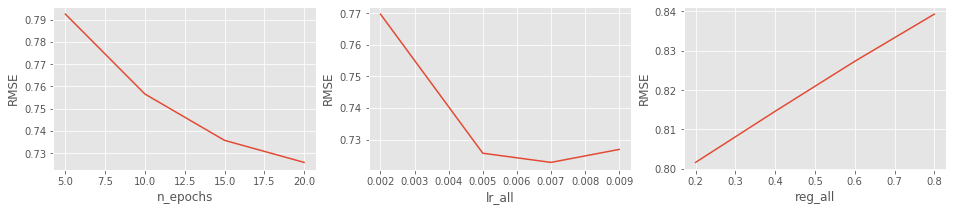

In [307]:
# Plot the accuracy for each parameter choice
fig,ax = plt.subplots(1,3,figsize=(16,3))
ax[0].plot(n_epochs, np.array([0.7925, 0.7566, 0.7358, 0.7259]))
ax[1].plot(lr_all, np.array([0.7697, 0.7257, 0.7228, 0.7269]))
ax[2].plot(reg_all, np.array([0.8016, 0.8146, 0.8273, 0.8393]))
ax[0].set_xlabel('n_epochs')
ax[0].set_ylabel('RMSE')
ax[1].set_xlabel('lr_all')
ax[1].set_ylabel('RMSE')
ax[2].set_xlabel('reg_all')
ax[2].set_ylabel('RMSE')

#### From the graphs above, we can tell which hyperparameters optimize the model performance based on the RMSE scores.

In [147]:
# Use the CVGridSearch to find the best hyperparameters for SVD
param_grid = {'n_epochs': [5, 10, 15, 20], 'lr_all': [0.002, 0.005, 0.007, 0.009],
              'reg_all': [0.2, 0.4, 0.6, 0.8]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(new_data)

# best RMSE score
#print(gs.best_score['rmse']) 

# combination of parameters that gave the best RMSE score
#print(gs.best_params['rmse'])

### (b) Fit model and test with dataset of 1% movies and 2% users

In [663]:
# instantiate a reader and read in our rating data
reader2 = Reader(rating_scale=(1, 5))
new_data2 = Dataset.load_from_df(df_ratings_drop_users2[['userId','movieId','rating']], reader2)

In [666]:
from surprise.model_selection import train_test_split
# split the dataset and take 75% as the traing set and 25% as the test set
trainset, testset = train_test_split(new_data2, test_size=0.25)

#trainset_small, testset_small = train_test_split(trainset, test_size=0.25)
algorithm = SVD()

# use cross_validation to test the accuracy of the training datasetand the test dataset, using metrics RSME and MAE
print(cross_validate(algorithm, new_data2, measures=['RMSE', 'MAE'], cv=5, verbose=True))

start = time.time()
# After checking the accuracy metrics, fit the model to the training dataset
algorithm.fit(trainset)

In [321]:
# Make predictions and check the accurancy
predictions = algorithm.test(testset)

end = time.time()
print(end - start)

accuracy.rmse(predictions)
accuracy.mae(predictions)

24.61958909034729
RMSE: 0.7094
MAE:  0.5377


0.5377226357912734

### (c) Fit model and test with dataset of 1% movies and 3% users

In [322]:
# instantiate a reader and read in our rating data
reader3 = Reader(rating_scale=(1, 5))
new_data3 = Dataset.load_from_df(df_ratings_drop_users3[['userId','movieId','rating']], reader3)

In [323]:
# split the dataset and take 75% as the traing set and 25% as the test set
trainset, testset = train_test_split(new_data3, test_size=0.25)

#trainset_small, testset_small = train_test_split(trainset, test_size=0.25)
algorithm = SVD()

# use cross_validation to test the accuracy of the training datasetand the test dataset, using metrics RSME and MAE
print(cross_validate(algorithm, new_data3, measures=['RMSE', 'MAE'], cv=5, verbose=True))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7042  0.7072  0.7034  0.7069  0.7048  0.7053  0.0015  
MAE (testset)     0.5330  0.5363  0.5333  0.5359  0.5333  0.5344  0.0015  
Fit time          35.64   35.65   36.40   36.67   35.99   36.07   0.41    
Test time         4.40    3.73    3.52    3.69    3.83    3.83    0.30    
{'test_rmse': array([0.70419166, 0.70715446, 0.70335024, 0.70690156, 0.70484448]), 'test_mae': array([0.53295448, 0.53634328, 0.53331561, 0.53591159, 0.5332612 ]), 'fit_time': (35.640161991119385, 35.646692991256714, 36.39831781387329, 36.67048788070679, 35.99429225921631), 'test_time': (4.401957988739014, 3.725130796432495, 3.5192582607269287, 3.685580015182495, 3.8293681144714355)}


In [324]:
start = time.time()
# After checking the accuracy metrics, fit the model to the training dataset
algorithm.fit(trainset)

In [325]:
# Make predictions and check the accurancy
predictions = algorithm.test(testset)

end = time.time()
print(end - start)

accuracy.rmse(predictions)
accuracy.mae(predictions)

37.73887896537781
RMSE: 0.7072
MAE:  0.5358


0.5357692011289796

### (d) Fit model and test with dataset of 2% movies and 3% users

In [326]:
# instantiate a reader and read in our rating data
reader4 = Reader(rating_scale=(1, 5))
new_data4 = Dataset.load_from_df(df_ratings_drop_users4[['userId','movieId','rating']], reader4)

In [327]:
# split the dataset and take 75% as the traing set and 25% as the test set
trainset, testset = train_test_split(new_data4, test_size=0.25)

#trainset_small, testset_small = train_test_split(trainset, test_size=0.25)
algorithm = SVD()

# use cross_validation to test the accuracy of the training datasetand the test dataset, using metrics RSME and MAE
print(cross_validate(algorithm, new_data4, measures=['RMSE', 'MAE'], cv=5, verbose=True))

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7099  0.7073  0.7112  0.7077  0.7086  0.7090  0.0014  
MAE (testset)     0.5389  0.5376  0.5399  0.5381  0.5379  0.5385  0.0008  
Fit time          60.88   61.28   61.21   64.34   61.31   61.80   1.28    
Test time         7.44    8.55    10.60   7.64    11.63   9.18    1.66    
{'test_rmse': array([0.70994267, 0.707345  , 0.7112284 , 0.70770184, 0.70862681]), 'test_mae': array([0.53894879, 0.53763629, 0.53988243, 0.53805029, 0.53789282]), 'fit_time': (60.88244295120239, 61.276803970336914, 61.20691990852356, 64.3365261554718, 61.305716037750244), 'test_time': (7.444140195846558, 8.552290916442871, 10.602921962738037, 7.642343044281006, 11.634684801101685)}


In [328]:
start = time.time()
# After checking the accuracy metrics, fit the model to the training dataset
algorithm.fit(trainset)

In [329]:
# Make predictions and check the accurancy
predictions = algorithm.test(testset)

end = time.time()
print(end - start)

accuracy.rmse(predictions)
accuracy.mae(predictions)

72.66835904121399
RMSE: 0.7117
MAE:  0.5404


0.5403634051912576

### Now look at the RMSE, MAE scores and the run-time of the model on each dataset with different size.

Text(0, 0.5, 'run-time')

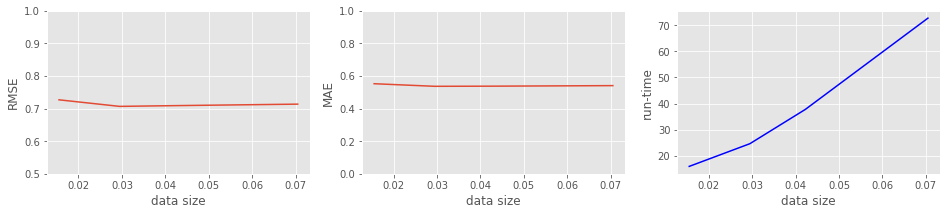

In [342]:
# Plot the accuracy for each dataset size choice
percentage = np.array([310413/20000263, 589681/20000263, 845185/20000263, 1409932/20000263])
RMSE_scores = np.array([0.7268, 0.7067, 0.7090, 0.7136])
MAE_scores = np. array([0.5524, 0.5365, 0.5373, 0.5407])
run_time = np.array([15.939538955688477, 24.61958909034729, 37.73887896537781, 72.66835904121399])
fig,ax = plt.subplots(1,3,figsize=(16,3))
ax[0].plot(percentage, RMSE_scores)
ax[1].plot(percentage, MAE_scores)
ax[2].plot(percentage, run_time, color='blue')
ax[0].set_ylim(0.5,1)
ax[1].set_ylim(0,1)
ax[0].set_xlabel('data size')
ax[0].set_ylabel('RMSE')
ax[1].set_xlabel('data size')
ax[1].set_ylabel('MAE')
ax[2].set_xlabel('data size')
ax[2].set_ylabel('run-time')

#### From the two graphs above, we can tell that the RMSE and MAE values do not change a lot as dataset sizes increase.
#### As the dataset size increases, the run-time also increases approximatrly linearly with respect to the dataset size. (The run-time includes both the training run-time and testing run-time)

### Recommend movies to a given user based on predicted movie ratings

In [331]:
# This function make recommendations to a given user based on the movie ratings the user has given
# Given a userId, the function predicts all movie ratings of this user and choose the 10 movies with the highest
# ratings
def pred_user_rating(ui):
    if ui in df_ratings_drop_users.userId.unique():
        ui_list = df_ratings_drop_users[df_ratings_drop_users.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [332]:
# Given the user with userId 100, make recommendations
user_id = 116
pred_user_rating(user_id)

,ratings
movies,
"Dark Knight, The (2008)",4.353475
300 (2007),4.094266
"Lock, Stock & Two Smoking Barrels (1998)",4.041330
"Departed, The (2006)",3.939277
Inception (2010),3.935722
Memento (2000),3.854132
"Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)",3.841154
Army of Darkness (1993),3.831812
City of God (Cidade de Deus) (2002),3.822930



## 3. Neighborhood-based (item-to-item)

In [673]:
# This function returns the matched index of the given movie name in the user-movie matrix
def fuzzy_matching(mapper, fav_movie, verbose=True):
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(str(title).lower(), str(fav_movie).lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [674]:
# This function returns the nearest n movies to recommend based on the given movie
def make_recommendation_movie(model_knn, data, mapper, fav_movie, n_recommendations):
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), 
                            key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [675]:
# Fit the NearestNeighbor model to the user-movie matrix, using cosine distance as the distance metric
model_knn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=40, n_jobs=-1)
model_knn2 = NearestNeighbors(metric='euclidean', algorithm='auto', n_neighbors=40, n_jobs=-1)

movie_user_mat_sparse = csr_matrix(ratings_f2_2.values)

In [676]:
# Map movie titles to movie Index in the user-movie matrix
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(movies.set_index('movieId').loc[ratings_f2_2.index].title))
}

In [677]:
# Now test the recommendation function given the inpout movie 'Maleficent'
testMovie =  'Batman'

make_recommendation_movie(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=testMovie,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Batman
Found possible matches in our database: ['Batman (1989)']

Recommendation system start to make inference
......

Recommendations for Batman:
1: Silence of the Lambs, The (1991), with distance of 0.05042044641102672
2: Star Wars: Episode IV - A New Hope (1977), with distance of 0.04952833520632005
3: Indiana Jones and the Last Crusade (1989), with distance of 0.04811177989958182
4: Terminator 2: Judgment Day (1991), with distance of 0.04805285120386904
5: Star Wars: Episode V - The Empire Strikes Back (1980), with distance of 0.04794701150978842
6: Ghostbusters (a.k.a. Ghost Busters) (1984), with distance of 0.045728549997158474
7: Jurassic Park (1993), with distance of 0.04509976515511649
8: Back to the Future (1985), with distance of 0.04504522353279772
9: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), with distance of 0.04380069063920822
10: Matrix, The (1999), with distance of 0.04378800148564488


In [678]:
make_recommendation_movie(
    model_knn=model_knn2,
    data=movie_user_mat_sparse,
    fav_movie=testMovie,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Batman
Found possible matches in our database: ['Batman (1989)']

Recommendation system start to make inference
......

Recommendations for Batman:
1: Speed (1994), with distance of 67.61471733284108
2: Star Wars: Episode VI - Return of the Jedi (1983), with distance of 67.30527468185537
3: Terminator, The (1984), with distance of 67.28670002311007
4: Fugitive, The (1993), with distance of 66.6258208204597
5: Terminator 2: Judgment Day (1991), with distance of 64.85753618508801
6: Indiana Jones and the Last Crusade (1989), with distance of 64.34865965970076
7: Back to the Future (1985), with distance of 64.1833311693932
8: Men in Black (a.k.a. MIB) (1997), with distance of 61.79603547154137
9: Ghostbusters (a.k.a. Ghost Busters) (1984), with distance of 60.66712454039667
10: Jurassic Park (1993), with distance of 58.35451996203893
